In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')

In [3]:
exclude_str = 't1Exclude'
extra_str = '_consist' # '_vol_norm' '_noboxcox' '_consist'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 200
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str,
                                                                                        parc_scale = parc_scale,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

### Setup output directory

In [4]:
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount_consist


## Load train/test .csv and setup node .csv

In [5]:
os.path.join(os.environ['TRTEDIR'])

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude'

In [6]:
# Load data
df = pd.read_csv(os.path.join(os.environ['TRTEDIR'], 'df_gradients.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(926, 45)


In [7]:
# # Retain 'adults'
# my_frac = 0.20
# my_cut = np.round(df.shape[0]*my_frac).astype(int)
# print(my_cut)
# df = df.sort_values('ageAtScan1', ascending = False).iloc[0:my_cut,:]

In [8]:
df['ageAtScan1_Years'].mean()

15.76965442764579

In [9]:
df['ageAtScan1_Years'].std()

3.292211495195789

In [10]:
num_subs = df.shape[0]; print(num_subs)
num_time = 120

num_connections = num_parcels * (num_parcels - 1) / 2; print(num_connections)

926
19900.0


## Load in time series, compute FC

In [11]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [12]:
# fc stored as 3d matrix, subjects of 3rd dim
roi_ts = np.zeros((num_time, num_parcels, num_subs))
fc = np.zeros((num_parcels, num_parcels, num_subs))

for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = os.environ['RSTS_NAME_TMP'].replace("bblid", str(index[0]))
    file_name = file_name.replace("scanid", str(index[1]))
    full_path = glob.glob(os.path.join(os.environ['RSTSDIR'], file_name))
    if i == 0: print(full_path)
        
    if len(full_path) > 0:
        roi_ts[:,:,i] = np.loadtxt(full_path[0])
        fc[:,:,i] = np.corrcoef(roi_ts[:,:,i], rowvar = False)
        # fisher r to z
        fc[:,:,i] = np.arctanh(fc[:,:,i])
        np.fill_diagonal(fc[:,:,i], 1)

        if np.any(np.isnan(fc[:,:,i])):
            subj_filt[i] = True

    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        roi_ts[:,:,i] = np.full((num_time, num_parcels), np.nan)
        fc[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

['/Volumes/ResProjects_2TB/ResData/PNC/processedData/restbold/restbold_201607151621/81287/20100114x2738/net/Schaefer200PNC/81287_20100114x2738_Schaefer200PNC_ts.1D']


/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in arctanh
  from ipykernel import kernelapp as app


In [13]:
np.sum(subj_filt)

0

In [14]:
if any(subj_filt):
    df = df.loc[~subj_filt]
    roi_ts = roi_ts[:,:,~subj_filt]
    fc = fc[:,:,~subj_filt]

In [15]:
# # Save out
# np.save(os.path.join(os.environ['MODELDIR'], 'fc'), fc)
# np.save(os.path.join(os.environ['MODELDIR'], 'roi_ts'), roi_ts)

### Generate participant gradients

In [16]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels
from brainspace.gradient.utils import dominant_set

In [17]:
# Generate template
pnc_conn_mat = np.nanmean(fc, axis = 2)
pnc_conn_mat[np.eye(num_parcels, dtype = bool)] = 0
# pnc_conn_mat = dominant_set(pnc_conn_mat, 0.10, as_sparse = False)

gm_template = GradientMaps(n_components = 10, approach='dm', kernel='normalized_angle')
gm_template.fit(pnc_conn_mat)

np.savetxt(os.path.join(os.environ['MODELDIR'],'pnc_grads_template.txt'),gm_template.gradients_)

# Plots

In [18]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)

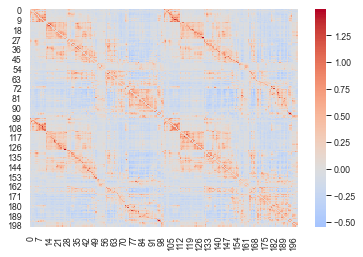

In [19]:
sns.heatmap(pnc_conn_mat, cmap = 'coolwarm', center = 0)

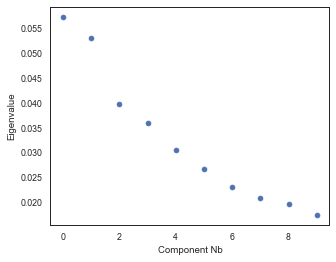

In [20]:
fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm_template.lambdas_.size), gm_template.lambdas_)
ax.set_xlabel('Component Nb')
ax.set_ylabel('Eigenvalue')

plt.show()

In [21]:
import matplotlib.image as mpimg
from brain_plot_func import brain_plot

In [22]:
subject_id = 'fsaverage'
surf = 'inflated'

In [23]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


## Brain plots nispat

In [24]:
for i in range(0,1):
    for hemi in ('lh', 'rh'):
        # Plots of univariate pheno correlation
        fig_str = hemi + '_gradient_' + str(i)
        parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                 hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')

        brain_plot(gm_template.gradients_[:,i], parcel_names, parc_file, fig_str, subject_id = subject_id, surf = surf, hemi = hemi, color = 'viridis_r', showcolorbar = True)

colormap sequential: [-8.53e-02, 8.99e-03, 1.03e-01] (opaque)
colormap sequential: [-8.53e-02, 8.99e-03, 1.03e-01] (opaque)
colormap sequential: [-8.24e-02, 9.92e-03, 1.02e-01] (opaque)
colormap sequential: [-8.24e-02, 9.92e-03, 1.02e-01] (opaque)


In [25]:
%matplotlib inline

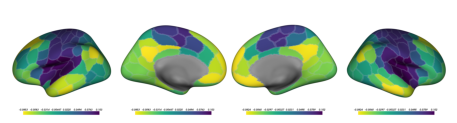

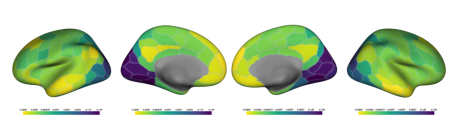

In [26]:
for i in range(0,2):

    f, axes = plt.subplots(1, 4)
    f.set_figwidth(8)
    f.set_figheight(2)
    plt.subplots_adjust(wspace=0, hspace=0)

    # column 0:
    fig_str = 'lh_gradient_' + str(i) + '.png'
    try:
    #     axes[0,0].set_title('Thickness (left)')
        image = mpimg.imread('lat_' + fig_str); axes[0].imshow(image); axes[0].axis('off')
    except FileNotFoundError: axes[0].axis('off')
    try:
        image = mpimg.imread('med_' + fig_str); axes[1].imshow(image); axes[1].axis('off')
    except FileNotFoundError: axes[1].axis('off')

    # column 1:
    fig_str = 'rh_gradient_' + str(i) + '.png'
    try:
    #     axes[0,1].set_title('Thickness (right)')
        image = mpimg.imread('med_' + fig_str); axes[2].imshow(image); axes[2].axis('off')
    except FileNotFoundError: axes[2].axis('off')
    try:
        image = mpimg.imread('lat_' + fig_str); axes[3].imshow(image); axes[3].axis('off')
    except FileNotFoundError: axes[3].axis('off')

    plt.show()
    f.savefig('gradient_' + str(i) + '.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [27]:
# for i in range(0,2):

#     f, axes = plt.subplots(2, 2)
#     f.set_figwidth(4)
#     f.set_figheight(4)
#     plt.subplots_adjust(wspace=0, hspace=0)

#     # column 0:
#     fig_str = 'lh_gradient_' + str(i) + '.png'
#     try:
#     #     axes[0,0].set_title('Thickness (left)')
#         image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
#     except FileNotFoundError: axes[0,0].axis('off')
#     try:
#         image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
#     except FileNotFoundError: axes[1,0].axis('off')

#     # column 1:
#     fig_str = 'rh_gradient_' + str(i) + '.png'
#     try:
#     #     axes[0,1].set_title('Thickness (right)')
#         image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
#     except FileNotFoundError: axes[0,1].axis('off')
#     try:
#         image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
#     except FileNotFoundError: axes[1,1].axis('off')

#     plt.show()
#     f.savefig('gradient_' + str(i) + '.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [28]:
# run_grads = False

In [29]:
# if run_grads == True:
#     grads = np.zeros((gm_template.gradients_.shape[0],gm_template.gradients_.shape[1],num_subs))
    
#     for (i, (index, row)) in enumerate(df.iterrows()):
#         fc_tmp = dominant_set(fc[:,:,i], 0.10, as_sparse = False)
#         gm_p = GradientMaps(n_components=2, approach='dm', kernel='normalized_angle', alignment='procrustes')
#         gm_p.fit(fc_tmp, reference = gm_template.gradients_)
#         grads[:,:,i] = gm_p.gradients_
    
#     np.save(os.path.join(os.environ['MODELDIR'],'pnc_grads'),grads)
# else:
#     grads = np.load(os.path.join(os.environ['MODELDIR'],'pnc_grads.npy'))

In [30]:
# # Save out
# np.save(os.path.join(os.environ['MODELDIR'], 'A'), A)
# df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node.csv'))
# df.to_csv(os.path.join(os.environ['MODELDIR'], 'df.csv'))

# if any(subj_filt_sc):
#     np.save(os.path.join(os.environ['MODELDIR'], 'subj_filt_sc'), subj_filt_sc)
# if any(subj_filt_fc):
#     np.save(os.path.join(os.environ['MODELDIR'], 'subj_filt_fc'), subj_filt_fc)